In [22]:
import glob
import xarray as xr
import netCDF4
import h5netcdf
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [23]:
# Please use WGET on our online data to download the data - this is from a server 
sst=xr.open_mfdataset('/glade/work/jrotondo/MLGEO2024_SeaIcePrediction/data/clean/sst_1979_2023_clean.nc', combine='by_coords') # Pulling in SST data - note elrady ai ready
sic=xr.open_mfdataset('/glade/derecho/scratch/geraint/MLFINALPROJDATA/ai_ready/ready_nh_sept_sic_19792023.nc', combine='by_coords').monthly_sic # Pulling in SIC data

### Discuss the current dimensions of the dataset and any challenges they present

Our data is temporally sparse with only 45 samples; however, has high dimensionality in its lat-lon grid with thousands of points. It is worth noting that these points are hihgly correlated at the local scale. We reduce this spatial correlation using both EOFs aand t-SNE and seek to find areas that expain large amount of vareince that might be averaged over or reduced to. We hope to use noise to expand our 45 long sample size 1979-2023 soon. 

In [24]:
sst

<xarray.Dataset>
Dimensions:    (date: 540, latitude: 161, longitude: 1440)
Coordinates:
    number     int64 ...
  * date       (date) int64 19790101 19790201 19790301 ... 20231101 20231201
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... 50.5 50.25 50.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    expver     (date) object dask.array<chunksize=(540,), meta=np.ndarray>
Data variables:
    sst        (date, latitude, longitude) float32 dask.array<chunksize=(540, 161, 1440), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T22:06 GRIB to CDM+CF via cfgrib-0.9.1...

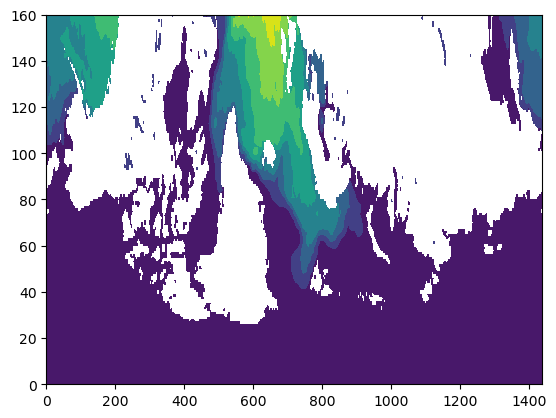

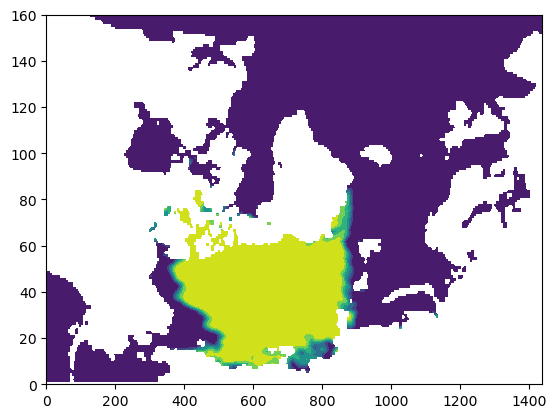

In [25]:
#Our maps
plt.contourf(sst.sst[0,:,:])
plt.show()
plt.contourf(sic[0,:,:])
plt.show()

In [26]:
sic

<xarray.DataArray 'monthly_sic' (time: 45, lat: 161, lon: 1440)>
dask.array<open_dataset-monthly_sic, shape=(45, 161, 1440), dtype=float64, chunksize=(45, 161, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01 1980-09-01 ... 2023-09-01
  * lon      (lon) float64 -180.0 -179.7 -179.5 -179.2 ... 179.5 179.7 180.0
  * lat      (lat) float64 50.0 50.25 50.5 50.75 51.0 ... 89.25 89.5 89.75 90.0
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]
    coordinates:          time ygrid xgrid

In [27]:
sic.lat

<xarray.DataArray 'lat' (lat: 161)>
array([50.  , 50.25, 50.5 , 50.75, 51.  , 51.25, 51.5 , 51.75, 52.  , 52.25,
       52.5 , 52.75, 53.  , 53.25, 53.5 , 53.75, 54.  , 54.25, 54.5 , 54.75,
       55.  , 55.25, 55.5 , 55.75, 56.  , 56.25, 56.5 , 56.75, 57.  , 57.25,
       57.5 , 57.75, 58.  , 58.25, 58.5 , 58.75, 59.  , 59.25, 59.5 , 59.75,
       60.  , 60.25, 60.5 , 60.75, 61.  , 61.25, 61.5 , 61.75, 62.  , 62.25,
       62.5 , 62.75, 63.  , 63.25, 63.5 , 63.75, 64.  , 64.25, 64.5 , 64.75,
       65.  , 65.25, 65.5 , 65.75, 66.  , 66.25, 66.5 , 66.75, 67.  , 67.25,
       67.5 , 67.75, 68.  , 68.25, 68.5 , 68.75, 69.  , 69.25, 69.5 , 69.75,
       70.  , 70.25, 70.5 , 70.75, 71.  , 71.25, 71.5 , 71.75, 72.  , 72.25,
       72.5 , 72.75, 73.  , 73.25, 73.5 , 73.75, 74.  , 74.25, 74.5 , 74.75,
       75.  , 75.25, 75.5 , 75.75, 76.  , 76.25, 76.5 , 76.75, 77.  , 77.25,
       77.5 , 77.75, 78.  , 78.25, 78.5 , 78.75, 79.  , 79.25, 79.5 , 79.75,
       80.  , 80.25, 80.5 , 80.75, 81.  , 81.25, 81.5 , 81.75, 82.  , 82.25,
       82.5 , 82.75, 83.  , 83.25, 83.5 , 83.75, 84.  , 84.25, 84.5 , 84.75,
       85.  , 85.25, 85.5 , 85.75, 86.  , 86.25, 86.5 , 86.75, 87.  , 87.25,
       87.5 , 87.75, 88.  , 88.25, 88.5 , 88.75, 89.  , 89.25, 89.5 , 89.75,
       90.  ])
Coordinates:
  * lat      (lat) float64 50.0 50.25 50.5 50.75 51.0 ... 89.25 89.5 89.75 90.0

In [28]:
sst

<xarray.Dataset>
Dimensions:    (date: 540, latitude: 161, longitude: 1440)
Coordinates:
    number     int64 ...
  * date       (date) int64 19790101 19790201 19790301 ... 20231101 20231201
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... 50.5 50.25 50.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    expver     (date) object dask.array<chunksize=(540,), meta=np.ndarray>
Data variables:
    sst        (date, latitude, longitude) float32 dask.array<chunksize=(540, 161, 1440), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T22:06 GRIB to CDM+CF via cfgrib-0.9.1...

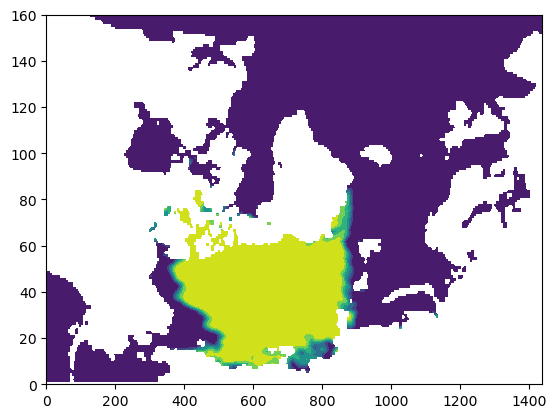

In [29]:
#Plt sic
plt.contourf(sic[0,:,:])

In [30]:
sic=xr.open_mfdataset('/glade/derecho/scratch/geraint/MLFINALPROJDATA/ai_ready/ready_nh_sept_sic_19792023.nc', combine='by_coords').monthly_sic # Pulling in SIC data
# Setting sic values to 0 if nan
sic = sic.fillna(0)
sic=sic.values
print(sic.shape)
# Redhaping to 2D
sic = sic.reshape(45, 161*1440)
print(sic.shape)

(45, 161, 1440)
(45, 231840)


In [31]:
# Filter SST data to include only dates with '09' in the month (September)
sst_september = sst.sel(date=sst.date.astype(str).str[4:6] == '09')
sst_september


<xarray.Dataset>
Dimensions:    (date: 45, latitude: 161, longitude: 1440)
Coordinates:
    number     int64 ...
  * date       (date) int64 19790901 19800901 19810901 ... 20220901 20230901
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... 50.5 50.25 50.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    expver     (date) object dask.array<chunksize=(45,), meta=np.ndarray>
Data variables:
    sst        (date, latitude, longitude) float32 dask.array<chunksize=(45, 161, 1440), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T22:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [32]:
sst = sst_september.sst.fillna(0)
sst=sst.values
print(sst.shape)
#Reshape to 45, 161*1440
sst=sst.reshape(45, 161*1440)
sst = sst
print(sst.shape)

(45, 161, 1440)
(45, 231840)


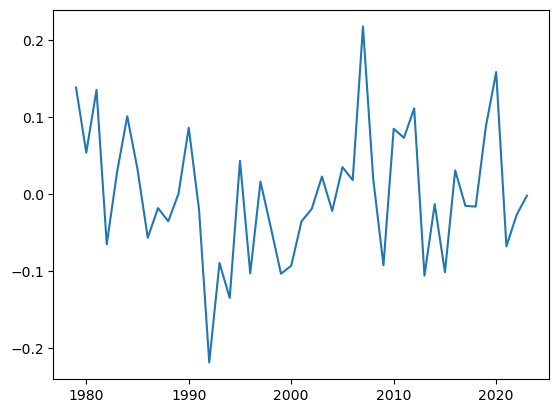

In [33]:
# Detrend SST
import scipy.signal as sig
sst_detrended = sig.detrend(sst, axis=0)
#Plot mean SST per year from 1979 until 2023
plt.plot(np.arange(1979,2023+1,1) ,np.mean(sst_detrended, axis=(1)))

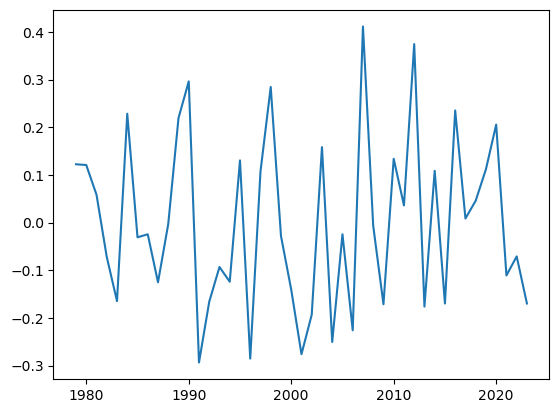

In [34]:
# Using Scalar, since we already found anomalies by detrending, we are effictlvey just dividng by standard deviation  since are values are already oreitnated around 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Remove move and nomralize by std
sst_scaled = scaler.fit_transform(sst_detrended)
plt.plot(np.arange(1979,2023+1,1) ,np.mean(sst_scaled, axis=(1)))

In [35]:
# Now we do PCA analaysis - EOF time!
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principal_components = pca.fit_transform(sst_scaled)

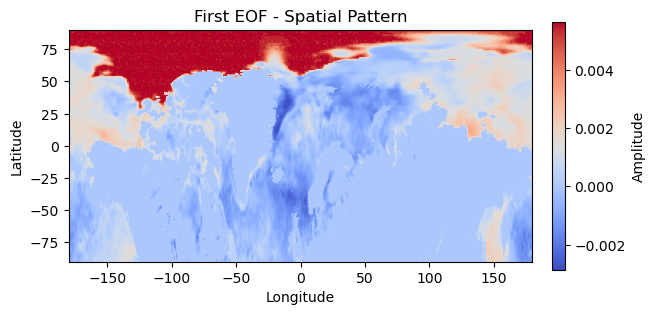

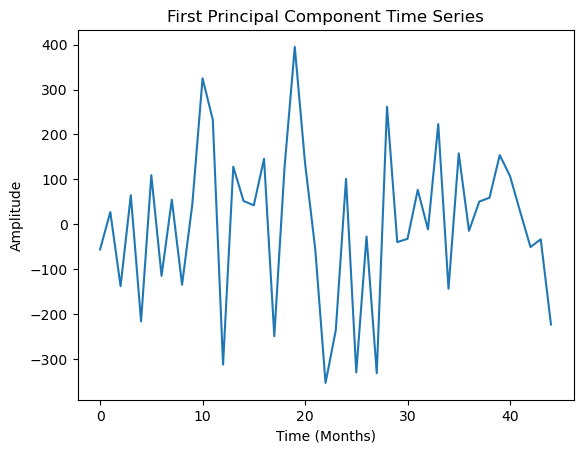

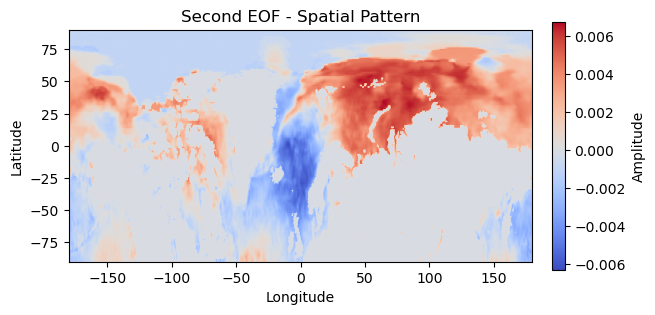

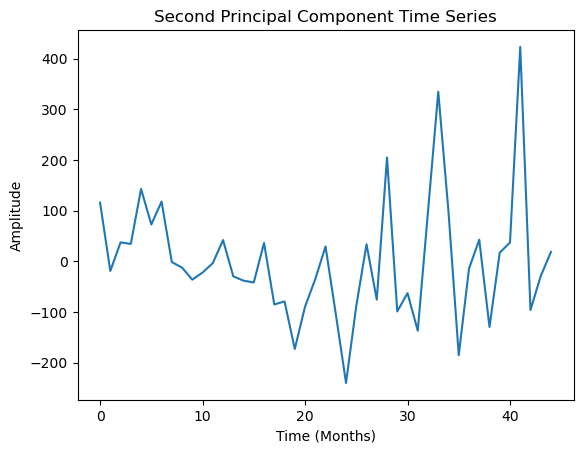

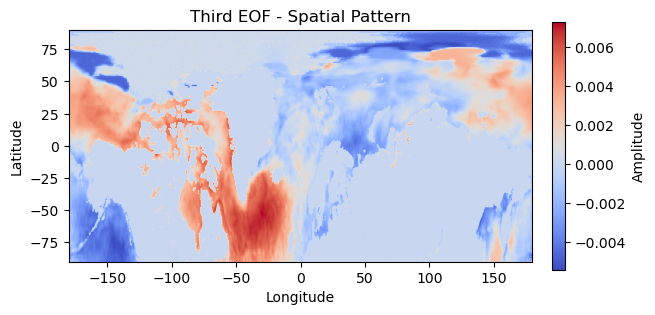

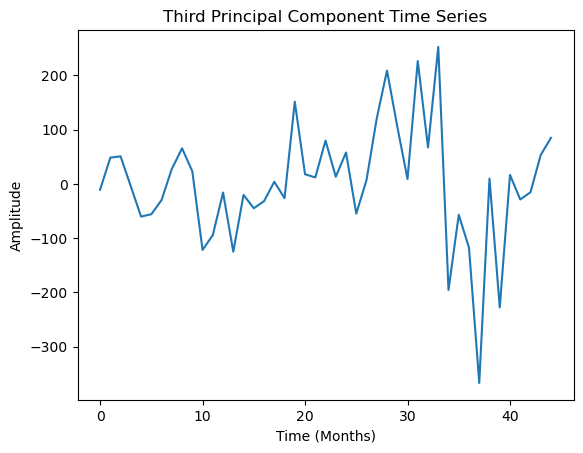

Explained Variance Ratios: [0.21854934 0.10491639 0.08698393 0.07520236 0.06221031]


In [36]:
# Now set up the first five EOFs
eofs = pca.components_.reshape(5, len(sst_september.latitude), len(sst_september.longitude))

# Plot the first EOF (Spatial Pattern)
plt.imshow(eofs[0], extent=[-180, 180, -90, 90], cmap='coolwarm')
plt.title('First EOF - Spatial Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the first principal component
plt.plot(principal_components[:, 0])
plt.title('First Principal Component Time Series')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Plot the second EOF (Spatial Pattern)
plt.imshow(eofs[1], extent=[-180, 180, -90, 90], cmap='coolwarm')
plt.title('Second EOF - Spatial Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the second principal component
plt.plot(principal_components[:, 1])
plt.title('Second Principal Component Time Series')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()


# Plot the third EOF (Spatial Pattern)
plt.imshow(eofs[2], extent=[-180, 180, -90, 90], cmap='coolwarm')
plt.title('Third EOF - Spatial Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the third principal component
plt.plot(principal_components[:, 2])
plt.title('Third Principal Component Time Series')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()


# Explained variance ratios
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

Text(0.5, 1.0, 'Explained Variance by EOF')

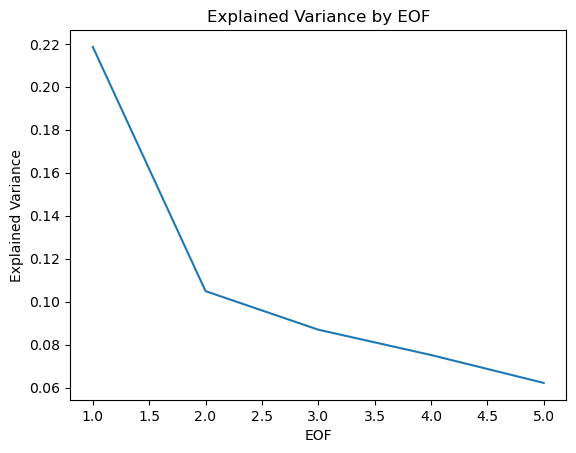

In [37]:
# Output explained varience by eof
plt.plot(np.arange(1,6,1), explained_variance) 
# Adding labels
plt.xlabel('EOF')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by EOF')

Importantly here, the first EOF explains most of the variance. E.g. most of the variance in the SST is caused by the sea ice... which makes sense. We should probably clip our data so to only be deep in the ice pack. Let's see how SST varies in the ice pack.

(45, 25, 1440)
(45, 36000)


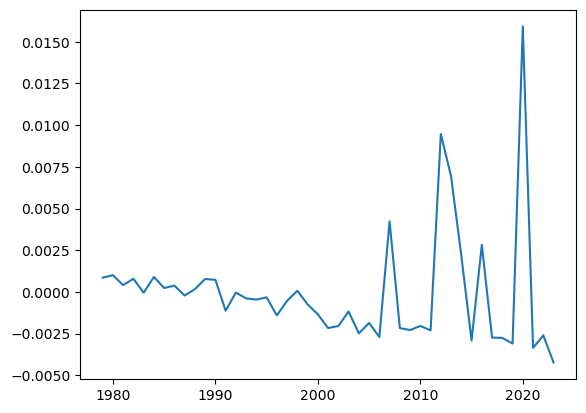

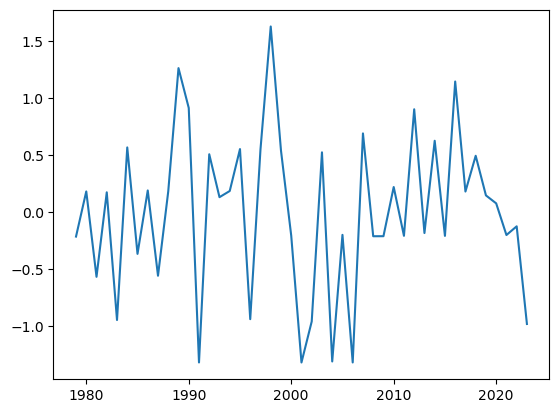

In [38]:
sst_trim = sst_september.sst.fillna(0)
sst_trim=sst_trim.isel(latitude=slice(0, 25)) # Just in the ice pack - very far north
sst_trim=sst_trim.values
print(sst_trim.shape)
#Reshape to 45, 161*1440
sst_trim=sst_trim.reshape(45, 25*1440)
print(sst_trim.shape)
# Detrend SST
import scipy.signal as sig
sst_trim = sig.detrend(sst_trim, axis=0)
#Plot mean SST per year from 1979 until 2023
plt.plot(np.arange(1979,2023+1,1) ,np.mean(sst_trim, axis=(1)))
plt.show()
# Using Scalar, since we already found anomalies by detrending, we are effictlvey just dividng by standard deviation  since are values are already oreitnated around 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Remove move and nomralize by std
sst_trim= scaler.fit_transform(sst_trim)
plt.plot(np.arange(1979,2023+1,1) ,np.mean(sst_trim, axis=(1)))
plt.show()
                       

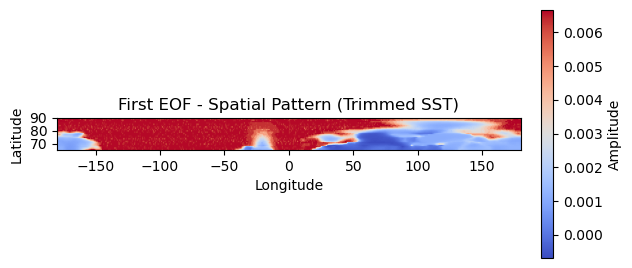

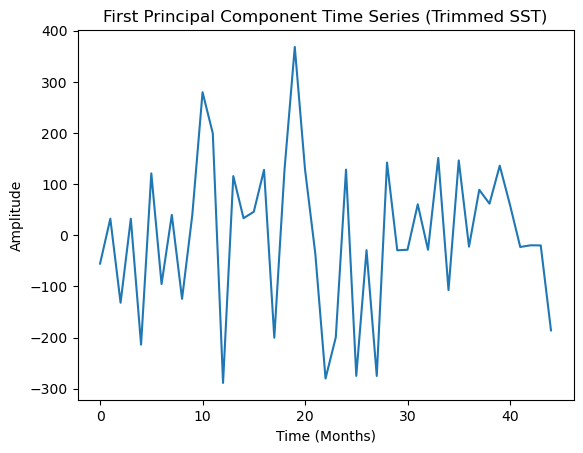

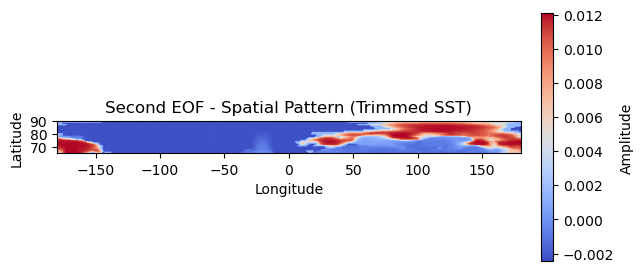

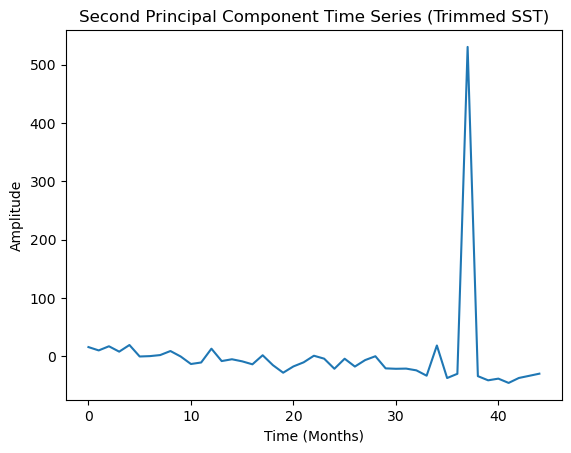

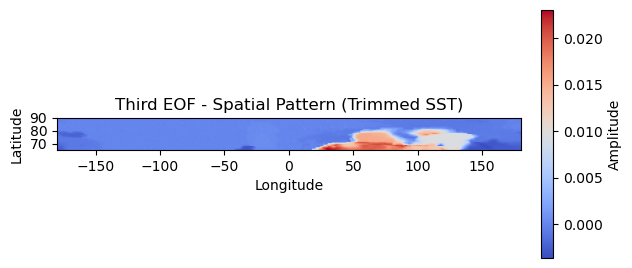

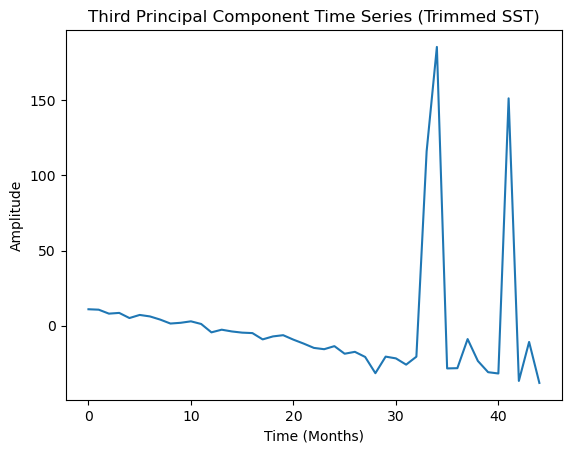

Explained Variance Ratios (Trimmed SST): [0.6140007  0.18612923 0.0514969  0.04408528 0.03065973]


In [39]:
# Now we do PCA analysis for trimmed SST data - EOF time!
pca_trim = PCA(n_components=5)
principal_components_trim = pca_trim.fit_transform(sst_trim)

# Now set up the first five EOFs for trimmed SST
eofs_trim = pca_trim.components_.reshape(5, 25, len(sst_september.longitude))

# Plot the first EOF (Spatial Pattern) for trimmed SST
plt.imshow(eofs_trim[0], extent=[-180, 180, 65, 90], cmap='coolwarm')
plt.title('First EOF - Spatial Pattern (Trimmed SST)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the first principal component for trimmed SST
plt.plot(principal_components_trim[:, 0])
plt.title('First Principal Component Time Series (Trimmed SST)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Plot the second EOF (Spatial Pattern) for trimmed SST
plt.imshow(eofs_trim[1], extent=[-180, 180, 65, 90], cmap='coolwarm')
plt.title('Second EOF - Spatial Pattern (Trimmed SST)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the second principal component for trimmed SST
plt.plot(principal_components_trim[:, 1])
plt.title('Second Principal Component Time Series (Trimmed SST)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Plot the third EOF (Spatial Pattern) for trimmed SST
plt.imshow(eofs_trim[2], extent=[-180, 180, 65, 90], cmap='coolwarm')
plt.title('Third EOF - Spatial Pattern (Trimmed SST)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the third principal component for trimmed SST
plt.plot(principal_components_trim[:, 2])
plt.title('Third Principal Component Time Series (Trimmed SST)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Explained variance ratios for trimmed SST
explained_variance_trim = pca_trim.explained_variance_ratio_
print("Explained Variance Ratios (Trimmed SST):", explained_variance_trim)

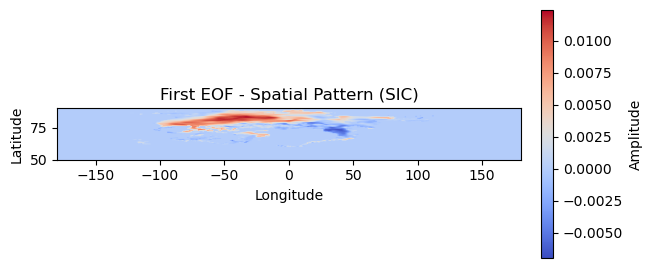

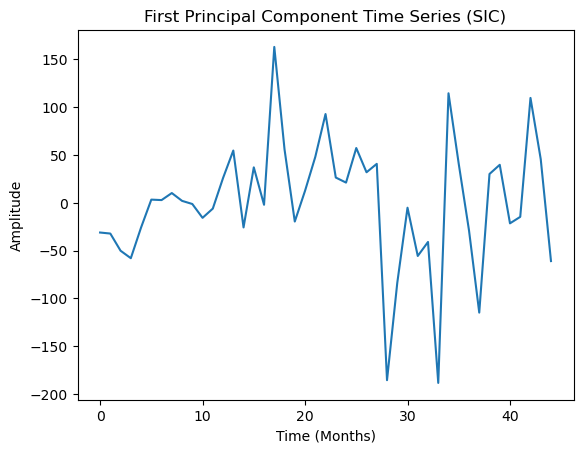

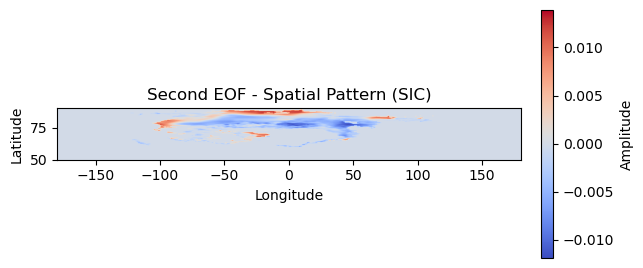

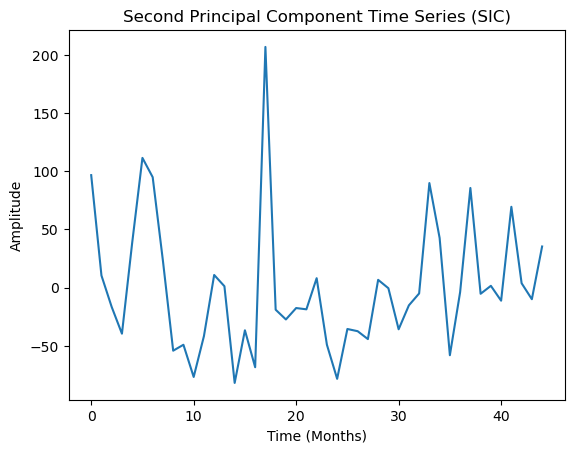

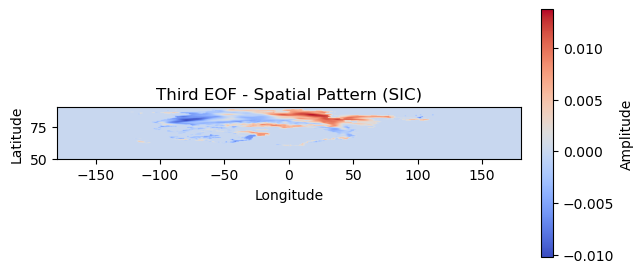

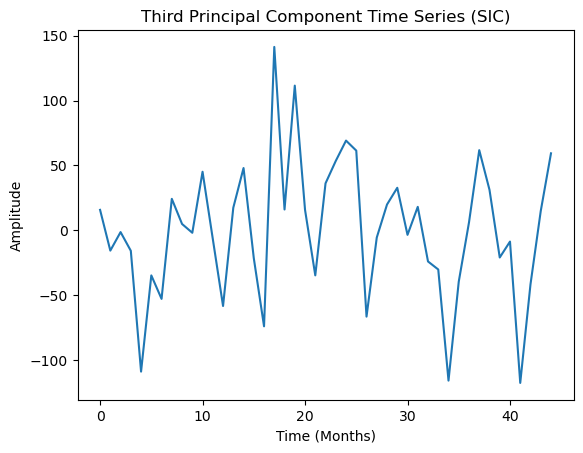

Explained Variance Ratios (SIC): [0.1108811  0.08366996 0.07159171 0.05974838 0.05189558]


In [40]:
# Detrend SIC
sic_detrended = sig.detrend(sic, axis=0)

# Normalize SIC
sic_scaled = scaler.fit_transform(sic_detrended.reshape(sic_detrended.shape[0], -1)).reshape(sic_detrended.shape)

# Perform PCA on SIC
pca_sic = PCA(n_components=5)
principal_components_sic = pca_sic.fit_transform(sic_scaled.reshape(sic_scaled.shape[0], -1))

# Set up the first five EOFs for SIC
eofs_sic = pca_sic.components_.reshape(5, len(sst_september.latitude), len(sst_september.longitude))

# Plot the first EOF (Spatial Pattern) for SIC
plt.imshow(eofs_sic[0], extent=[-180, 180, 50, 90], cmap='coolwarm')
plt.title('First EOF - Spatial Pattern (SIC)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the first principal component for SIC
plt.plot(principal_components_sic[:, 0])
plt.title('First Principal Component Time Series (SIC)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Plot the second EOF (Spatial Pattern) for SIC
plt.imshow(eofs_sic[1], extent=[-180, 180, 50, 90], cmap='coolwarm')
plt.title('Second EOF - Spatial Pattern (SIC)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the second principal component for SIC
plt.plot(principal_components_sic[:, 1])
plt.title('Second Principal Component Time Series (SIC)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Plot the third EOF (Spatial Pattern) for SIC
plt.imshow(eofs_sic[2], extent=[-180, 180, 50, 90], cmap='coolwarm')
plt.title('Third EOF - Spatial Pattern (SIC)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the third principal component for SIC
plt.plot(principal_components_sic[:, 2])
plt.title('Third Principal Component Time Series (SIC)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Explained variance ratios for SIC
explained_variance_sic = pca_sic.explained_variance_ratio_
print("Explained Variance Ratios (SIC):", explained_variance_sic)

Text(0.5, 1.0, 'Explained Variance by EOF (SIC)')

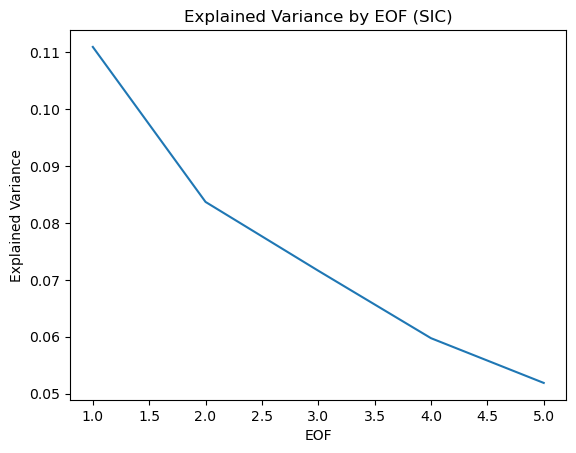

In [41]:
# Output explained varience by eof for SIC
plt.plot(np.arange(1,6,1), explained_variance_sic)
# Adding labels
plt.xlabel('EOF')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by EOF (SIC)')

In [45]:
np.max(sic)

1.0

In [48]:
sic_trim=xr.open_mfdataset('/glade/derecho/scratch/geraint/MLFINALPROJDATA/ai_ready/ready_nh_sept_sic_19792023.nc', combine='by_coords').monthly_sic # Pulling in SIC data
# Setting sic values to 0 if nan
sic_trim = sic_trim.fillna(0)
sic_trim=sic_trim.isel(lat=slice(0, 25))
sic_trim=sic_trim.values
print(sic_trim.shape)
# Redhaping to 2D
sic_trim = sic_trim.reshape(45, 25*1440)
print(sic_trim.shape)

(45, 25, 1440)
(45, 36000)


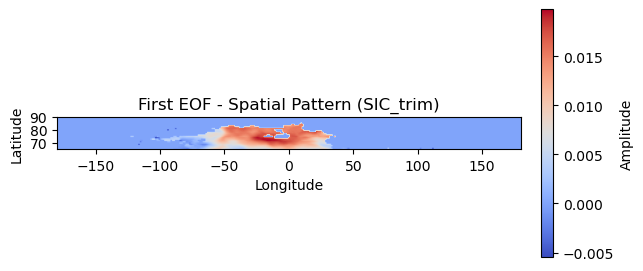

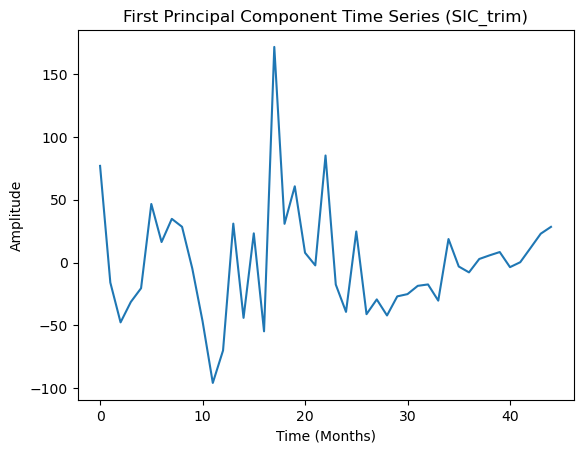

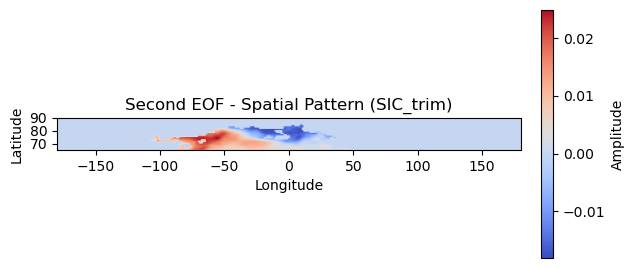

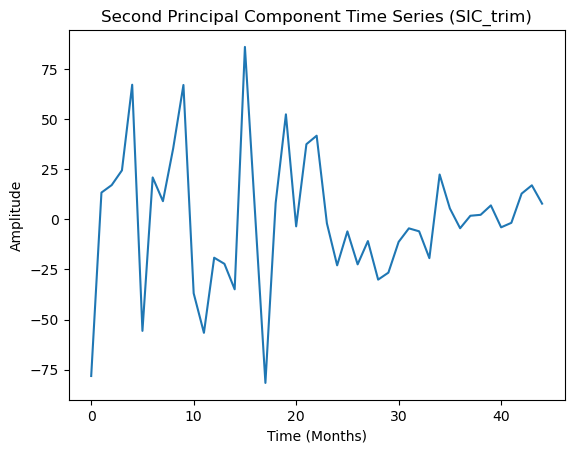

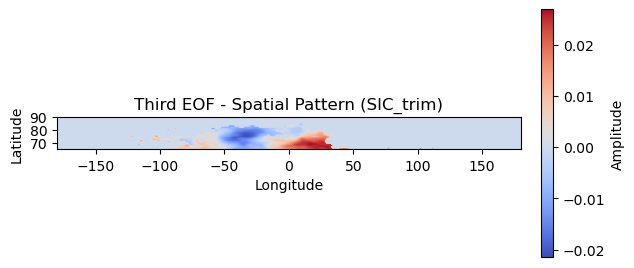

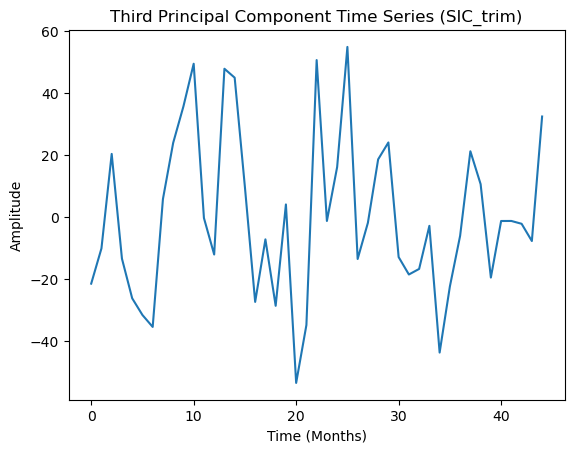

Explained Variance Ratios (SIC_trim): [0.28971244 0.1678849  0.0992686  0.07261497 0.0566497 ]


In [49]:
# Detrend SIC_trim
sic_trim_detrended = sig.detrend(sic_trim, axis=0)

# Normalize SIC_trim
sic_trim_scaled = scaler.fit_transform(sic_trim_detrended.reshape(sic_trim_detrended.shape[0], -1)).reshape(sic_trim_detrended.shape)

# Perform PCA on SIC_trim
pca_sic_trim = PCA(n_components=5)
principal_components_sic_trim = pca_sic_trim.fit_transform(sic_trim_scaled.reshape(sic_trim_scaled.shape[0], -1))

# Set up the first five EOFs for SIC_trim
eofs_sic_trim = pca_sic_trim.components_.reshape(5, 25, len(sst_september.longitude))

# Plot the first EOF (Spatial Pattern) for SIC_trim
plt.imshow(eofs_sic_trim[0], extent=[-180, 180, 65, 90], cmap='coolwarm')
plt.title('First EOF - Spatial Pattern (SIC_trim)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the first principal component for SIC_trim
plt.plot(principal_components_sic_trim[:, 0])
plt.title('First Principal Component Time Series (SIC_trim)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Plot the second EOF (Spatial Pattern) for SIC_trim
plt.imshow(eofs_sic_trim[1], extent=[-180, 180, 65, 90], cmap='coolwarm')
plt.title('Second EOF - Spatial Pattern (SIC_trim)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the second principal component for SIC_trim
plt.plot(principal_components_sic_trim[:, 1])
plt.title('Second Principal Component Time Series (SIC_trim)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Plot the third EOF (Spatial Pattern) for SIC_trim
plt.imshow(eofs_sic_trim[2], extent=[-180, 180, 65, 90], cmap='coolwarm')
plt.title('Third EOF - Spatial Pattern (SIC_trim)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude', fraction=0.025, pad=0.04)
plt.show()

# Plot the corresponding time series of the third principal component for SIC_trim
plt.plot(principal_components_sic_trim[:, 2])
plt.title('Third Principal Component Time Series (SIC_trim)')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Explained variance ratios for SIC_trim
explained_variance_sic_trim = pca_sic_trim.explained_variance_ratio_
print("Explained Variance Ratios (SIC_trim):", explained_variance_sic_trim)

Text(0.5, 1.0, 'Explained Variance by EOF (SIC)')

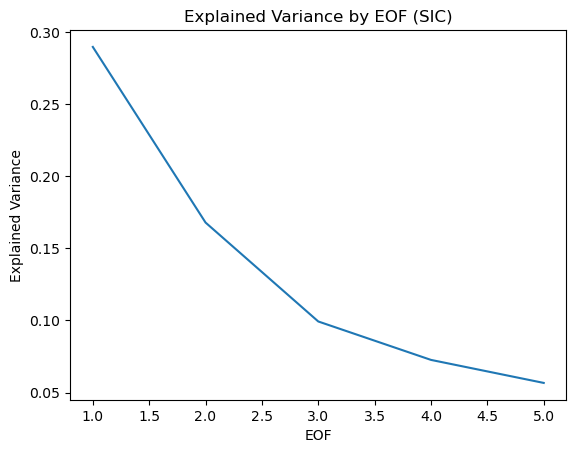

In [50]:
# Output explained varience by eof for SIC
plt.plot(np.arange(1,6,1), explained_variance_sic_trim)
# Adding labels
plt.xlabel('EOF')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by EOF (SIC)')

6.994437e-06


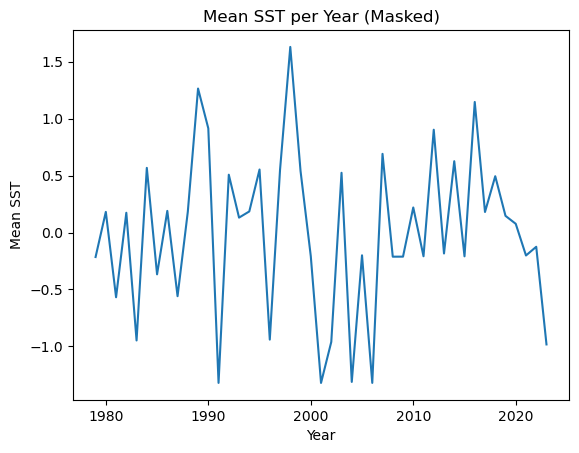

In [54]:
# Mask 0s in sst_trim
sst_trim_masked = np.ma.masked_equal(sst_trim, 0)
print(np.min(abs(sst_trim_masked))) # No zeros left
# Plot mean SST per year from 1979 until 2023 for masked data
plt.plot(np.arange(1979, 2023 + 1, 1), np.mean(sst_trim_masked, axis=(1)))
plt.title('Mean SST per Year (Masked)')
plt.xlabel('Year')
plt.ylabel('Mean SST')
plt.show()

In [55]:
# Now do t-Distributed Stochastic Neighbor Embedding (t-SNE) for SST
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
sst_tsne = tsne.fit_transform(sst_trim_masked)
print(sst_tsne.shape)

(45, 2)


Text(0.5, 1.0, 't-SNE Results for SST_trim')

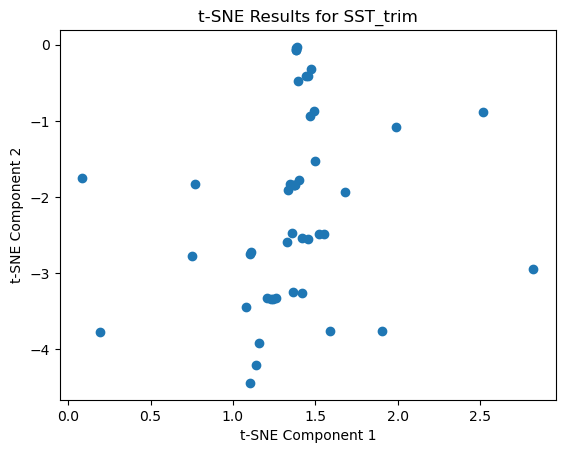

In [56]:
# Plot t-SNE results for SST
plt.scatter(sst_tsne[:, 0], sst_tsne[:, 1])
# Labels
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Results for SST_trim')

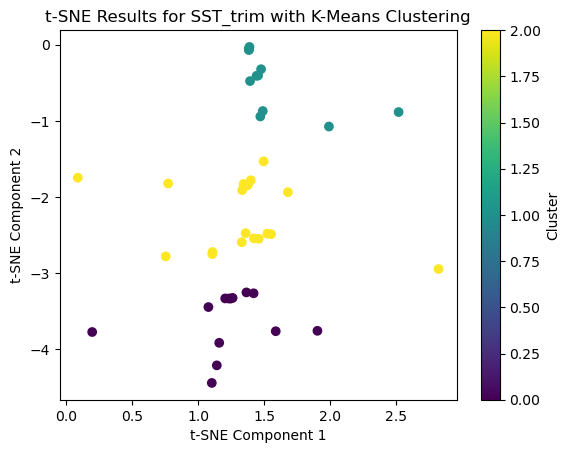

In [61]:
from sklearn.cluster import KMeans

# Perform k-means clustering on the t-SNE results
kmeans = KMeans(n_clusters=3, random_state=42)
sst_tsne_clusters = kmeans.fit_predict(sst_tsne)

# Plot the clustered t-SNE results
plt.scatter(sst_tsne[:, 0], sst_tsne[:, 1], c=sst_tsne_clusters, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Results for SST_trim with K-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()

Three clusters here seemed logical...

In [64]:
# Mask zeros from sic_trim
sic_trim_masked = np.ma.masked_equal(sic, 0)
# Now do t-Distributed Stochastic Neighbor Embedding (t-SNE) for SST
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
sic_tsne = tsne.fit_transform(sic_trim_masked)
print(sic_tsne.shape)

(45, 2)


Text(0.5, 1.0, 't-SNE Results for SIC_trim')

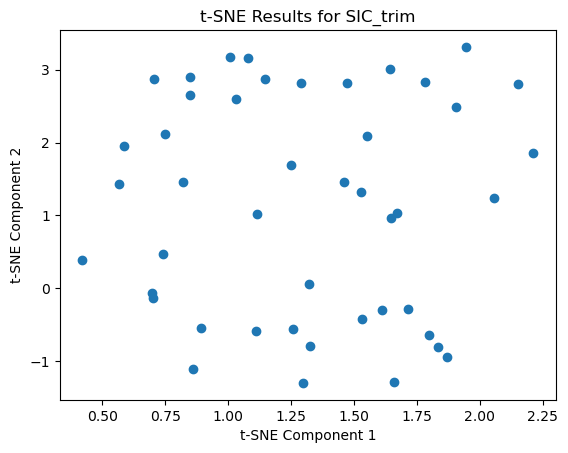

In [65]:
# Plot t-SNE results for SST
plt.scatter(sic_tsne[:, 0], sic_tsne[:, 1])
# Labels
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Results for SIC_trim')

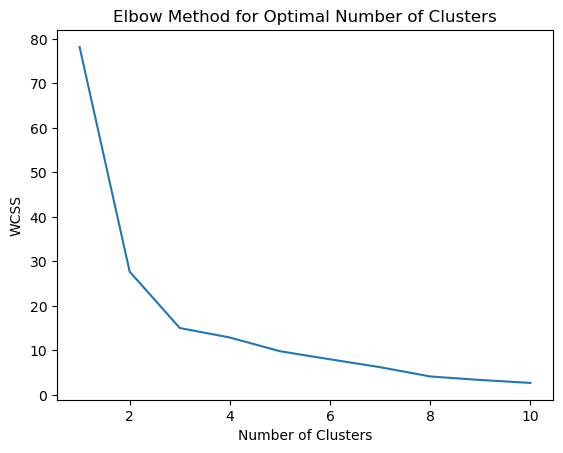

In [66]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(sst_tsne)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method results
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

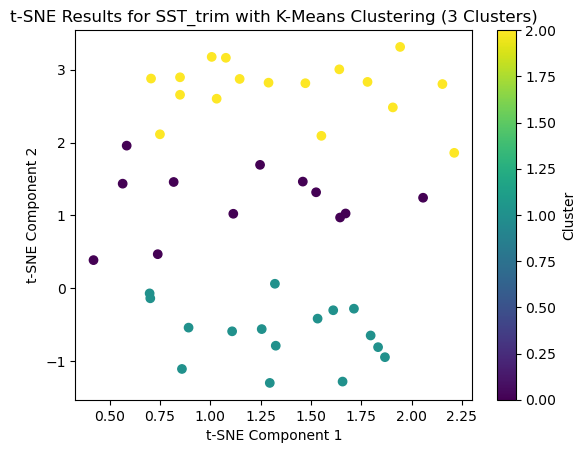

In [68]:
# Perform k-means clustering on the t-SNE results with 3 clusters
kmeans_3_clusters = KMeans(n_clusters=3, random_state=42)
sic_tsne_clusters_3 = kmeans_3_clusters.fit_predict(sic_tsne)

# Plot the clustered t-SNE results with 3 clusters
plt.scatter(sic_tsne[:, 0], sic_tsne[:, 1], c=sic_tsne_clusters_3, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Results for SST_trim with K-Means Clustering (3 Clusters)')
plt.colorbar(label='Cluster')
plt.show()

(90, 2)


Text(0, 0.5, 't-SNE Component 2')

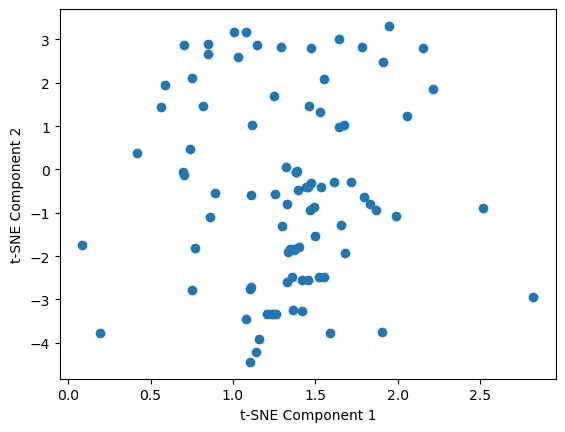

In [71]:
# Combine sic_tnse and sst_tsne
combined_tsne = np.concatenate((sst_tsne, sic_tsne), axis=0)
print(combined_tsne.shape)
#Plot combined t_sne as above
plt.scatter(combined_tsne[:, 0], combined_tsne[:, 1])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

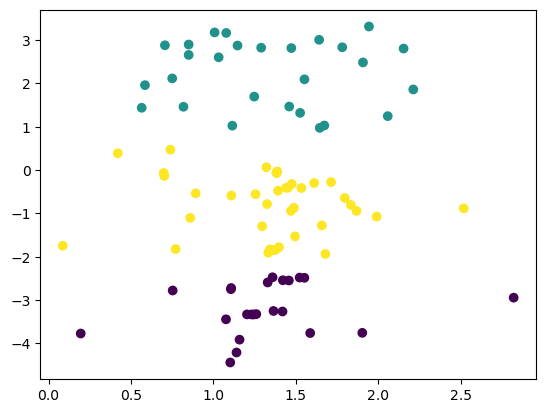

In [72]:
#Again making 3-clusters seems logical
kmeans_3_clusters_combined = KMeans(n_clusters=3, random_state=42)
combined_tsne_clusters_3 = kmeans_3_clusters_combined.fit_predict(combined_tsne)
#plotting
plt.scatter(combined_tsne[:, 0], combined_tsne[:, 1], c=combined_tsne_clusters_3, cmap='viridis')
#This was honestly, not the best use of time, but it was a good thought experiment


###Discuss the implications of dimensionality reduction on your dataset.

From our analaysis one can both visualize areas important to replicate e.g. when only looking at SST and SIC in the highest latitudes one can see that (from our EOFs) oen can see a dipole pattern across the arctic with the Canadian archipeligo opposing the ocean above Siberia. Noting that we only consider the first EOF as it by far explains the most vairence of SIC and SST. Therefore, it is important to include smaple from both sides of the arctic. T-SNE analssis further shows us that when collopsing our data into 2 dimensions in both SIC and SST there is the oppurtunity to represent our data by only two attriubutes in three areas if we just collapse our data down e.g. we need not include a hole map but nodes from this reduced data set. Natrually, the current dimesnions are too high, but by analyzing a few regions (e.g. the dipole) or by reducing to 2D and using an average of our cluster we might reduce our data set sufficently.